# 전처리 함수화

In [1]:
import sys
from pathlib import Path

# 상대 경로 사용
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'

# 맨 앞에 추가
sys.path.insert(0, str(PROJECT_ROOT))

# Python 내장 code 모듈 캐시만 임시 제거
if 'code' in sys.modules:
    del sys.modules['code']

# 이제 import
from code.loading import DataLoader

loader2 = DataLoader(
    start=2020,
    end=2025,
    output_file=DATA_DIR / 'maude_sample.parquet',
    max_workers=4
)

In [2]:
adapter = 'polars'
polars_kwargs = {
    'use_statistics': True,
    'parallel': 'auto',
    'low_memory': False,
    'rechunk': False,
    'cache': True,
}

df = loader2.load(adapter=adapter, **polars_kwargs)


📖 /Users/t2023-m0103/Desktop/sparta/final_project/data/maude_sample.parquet 로딩 중... (adapter=polars)


In [3]:
import polars as pl

In [4]:
df.select(pl.count()).collect()

/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/4004224096.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  df.select(pl.count()).collect()


count
u32
2627150


In [5]:
len(df.columns)

/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/776963103.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  len(df.columns)


403

In [6]:
lf = df.select(['device_0_manufacturer_d_name', 'device_0_manufacturer_d_zip_code', 'device_0_manufacturer_d_postal_code', 'patient_0_patient_sequence_number', 'patient_0_patient_age','patient_0_sequence_number_outcome', 'mdr_text_0_text', 'mdr_text_0_text_type_code'])
lf.head().collect()

device_0_manufacturer_d_name,device_0_manufacturer_d_zip_code,device_0_manufacturer_d_postal_code,patient_0_patient_sequence_number,patient_0_patient_age,patient_0_sequence_number_outcome,mdr_text_0_text,mdr_text_0_text_type_code
str,str,str,str,str,str,str,str
null,null,null,null,null,null,null,null
"""LIFE2O""","""76051""","""76051""","""1""",null,null,null,null
"""FISHER & PAYKEL HEALTHCARE LTD""","""2013""","""2013""","""1""",null,null,null,null
"""DT MEDTECH LLC, A VILEX COMPAN…","""37110""","""37110""","""1""",null,null,null,null
"""LIFE2O""","""76051""","""76051""","""1""",null,null,null,null


In [7]:
lf.select(pl.col('patient_0_patient_sequence_number').value_counts(sort=True)).collect()

patient_0_patient_sequence_number
struct[2]
"{""1"",2627145}"
"{null,5}"


patient_0_patient_sequence_number 버리기.

In [8]:
lf.select(['device_0_manufacturer_d_zip_code', 'device_0_manufacturer_d_postal_code', 'device_0_manufacturer_d_name']).unique().head().collect()

device_0_manufacturer_d_zip_code,device_0_manufacturer_d_postal_code,device_0_manufacturer_d_name
str,str,str
null,null,"""BLOCK DRUG CO., INC"""
"""63110""","""63110""","""ALLIED HEALTHCARE PRODCUTS INC"""
"""02048""","""02048""","""COVIDIEN MANSFIELD"""
null,null,"""ABBOTT LABORATORIES/ST JUDE ME…"
null,null,"""TELEFLEX, INC. / TELEFLEX LLC …"


In [9]:
null_percentage_lf = lf.select(
    [
        (pl.col(col).null_count() / pl.len()).alias(f"{col}_null_percentage")
        for col in lf.columns
    ]
)

null_percentage_lf.collect()

/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/2509628790.py:4: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col in lf.columns


device_0_manufacturer_d_name_null_percentage,device_0_manufacturer_d_zip_code_null_percentage,device_0_manufacturer_d_postal_code_null_percentage,patient_0_patient_sequence_number_null_percentage,patient_0_patient_age_null_percentage,patient_0_sequence_number_outcome_null_percentage,mdr_text_0_text_null_percentage,mdr_text_0_text_type_code_null_percentage
f64,f64,f64,f64,f64,f64,f64,f64
0.001632,0.046363,0.046363,0.000002,0.021268,0.570188,0.000083,0.000083


device_0_manufacturer_d_name, device_0_manufacturer_d_zip_code, device_0_manufacturer_d_postal_code 이 3가지는 null 값이 99.9996%임.

patient_0_patient_sequence_number는 전부 1이라 삭제 예정

patient_0_patient_age는 null값이 2%

patient_0_sequence_number_outcome은 null값이 56.9737%


In [10]:
null_percentage_df = df.select(
    [
        (pl.col(col).null_count() / pl.len()).alias(f"{col}_null_percentage")
        for col in ['manufacturer_g1_name', 'manufacturer_g1_postal_code', 'manufacturer_g1_zip_code']
    ]
)

null_percentage_df.collect()

manufacturer_g1_name_null_percentage,manufacturer_g1_postal_code_null_percentage,manufacturer_g1_zip_code_null_percentage
f64,f64,f64
0.34997,0.416835,0.416835


manufacturer_g1_name, manufacturer_g1_postal_code로 이름 매칭하기로

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

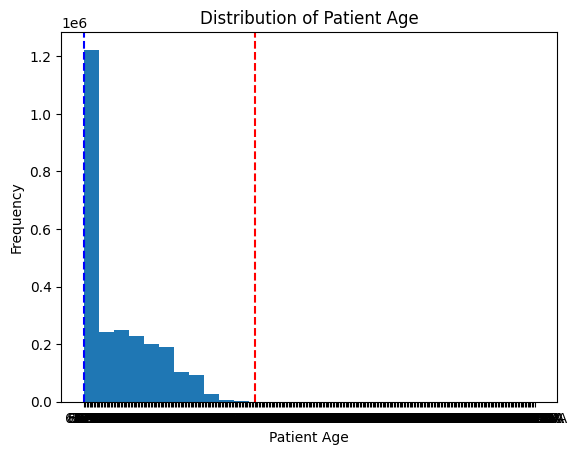

In [12]:
age = lf.select("patient_0_patient_age").collect().to_pandas()["patient_0_patient_age"]

# Null 제거
age = age.dropna()

plt.hist(age, bins=30)
plt.xlabel("Patient Age")
plt.ylabel("Frequency")
plt.axvline(x=120, color='r', linestyle='--', label='Age 120')
plt.axvline(x=0, color='b', linestyle='--', label='Age 0')
plt.title("Distribution of Patient Age")
plt.show()

In [13]:
age = lf.select("patient_0_patient_age").collect().to_pandas()["patient_0_patient_age"]
age.head(100)

0      None
1      None
2      None
3      None
4      None
      ...  
95    45 YR
96       NA
97    66 YR
98       NA
99    84 YR
Name: patient_0_patient_age, Length: 100, dtype: object

나이는 120세 이하만 남기기로

In [14]:
lf.filter(
    pl.col("patient_0_sequence_number_outcome").is_not_null()
).head().collect()


device_0_manufacturer_d_name,device_0_manufacturer_d_zip_code,device_0_manufacturer_d_postal_code,patient_0_patient_sequence_number,patient_0_patient_age,patient_0_sequence_number_outcome,mdr_text_0_text,mdr_text_0_text_type_code
str,str,str,str,str,str,str,str
null,null,null,"""1""","""61 YR""","""['Required Intervention']""","""ADDITIONAL INFORMATION: THE C…","""Additional Manufacturer Narrat…"
null,null,null,"""1""","""80 YR""","""['Required Intervention']""","""ADDITIONAL INFORMATION: THE PA…","""Additional Manufacturer Narrat…"
"""ST. JUDE MEDICAL, INC.(CRM-SYL…","""91342""","""91342""","""1""","""69 YR""","""['Required Intervention']""","""IT WAS REPORTED THAT THE PATIE…","""Description of Event or Proble…"
"""THORATEC CORPORATION""","""94588""","""94588""","""1""","""77 YR""","""['Death']""","""IT WAS REPORTED THROUGH PATIEN…","""Description of Event or Proble…"
"""BOSTON SCIENTIFIC NEUROMODULAT…","""91355""","""91355""","""1""","""55 YR""","""['Required Intervention']""","""BLOCK B3: APPROXIMATED BASED O…","""Additional Manufacturer Narrat…"


In [15]:
lf.select(pl.col('patient_0_sequence_number_outcome').value_counts()).collect()

patient_0_sequence_number_outcome
struct[2]
"{""['Hospitalization', ' C', ' L']"",2}"
"{""['Other', ' R', ' S', ' L']"",1}"
"{""['Required Intervention', ' D', ' L']"",53}"
"{""['Hospitalization', ' R', ' O', ' L', ' S']"",2}"
"{""['Life Threatening', ' C', ' H']"",1}"
…
"{""['Required Intervention', ' S', ' O', ' H']"",2}"
"{""['Required Intervention', ' R']"",1013}"
"{""['Life Threatening', ' H', ' O']"",11}"


In [16]:
cleaned = (
    lf
    .with_columns(
        pl.col("patient_0_sequence_number_outcome")
        .str.replace_all(r'^\[|\]$', "")     # 대괄호 제거
        .str.replace_all(r"'", "")  # 따옴표 제거
        .str.split(",")    # 리스트로 변환
        .alias("out_list")
    )
)

result = (
    cleaned
    .explode("out_list")
    .select(
        pl.col("out_list").str.strip_chars().alias("outcome")  # explode 후 strip
    )
    .group_by("outcome")
    .count()
    .sort("count", descending=True)
    .collect().to_pandas()
)
result

/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/151379726.py:19: DeprecationWarning: `count` was renamed; use `len` instead
  .count()


,outcome,count
0,None,1497969
1,Required Intervention,915577
2,Other,132770
3,Hospitalization,53055
4,R,48332
5,H,41427
6,Death,13230
7,Life Threatening,11165
8,L,8747
9,O,8560


Death - D

Disability - S

일 가능성이 높아보임. 그렇게 처리할 예정.

1. udi id로 검색하기 https://api.fda.gov/device/udi.json?search=identifiers.id:(01)SW11677
2. 안 나오면 model 번호로 검색하기 https://api.fda.gov/device/udi.json?search=version_or_model_number:SW11677

In [17]:
df.select('device_0_udi_di').head().collect()

device_0_udi_di
str
null
null
"""09420012422347"""
null
null


In [18]:
df.select(pl.col("device_0_device_operator").unique()).collect()

device_0_device_operator
str
"""LAY USER/PATIENT"""
null
"""HEALTH PROFESSIONAL"""
"""OTHER"""
"""0"""


In [19]:
df.select([
    pl.col("device_0_device_operator").n_unique().alias("n_unique"),
    pl.col("device_0_device_operator").null_count().alias("null_count")
]).collect()

n_unique,null_count
u32,u32
5,327704


In [20]:
df.head(10).collect()

adverse_event_flag,date_added,date_changed,date_facility_aware,date_manufacturer_received,date_of_event,date_received,date_report,date_report_to_fda,date_report_to_manufacturer,device,device_0_brand_name,device_0_catalog_number,device_0_combination_product_flag,device_0_date_received,device_0_date_removed_flag,device_0_date_removed_year,device_0_date_returned_to_manufacturer,device_0_device_age_text,device_0_device_availability,device_0_device_evaluated_by_manufacturer,device_0_device_event_key,device_0_device_operator,device_0_device_report_product_code,device_0_device_sequence_number,device_0_expiration_date_of_device,device_0_generic_name,device_0_implant_date_year,device_0_implant_flag,device_0_lot_number,device_0_manufacturer_d_address_1,device_0_manufacturer_d_address_2,device_0_manufacturer_d_city,device_0_manufacturer_d_country,device_0_manufacturer_d_name,device_0_manufacturer_d_postal_code,device_0_manufacturer_d_state,…,patient_2_patient_ethnicity,patient_2_patient_race,patient_2_patient_sequence_number,patient_2_patient_sex,patient_2_patient_weight,patient_2_sequence_number_outcome,patient_2_sequence_number_treatment,patient_3_date_received,patient_3_patient_age,patient_3_patient_ethnicity,patient_3_patient_race,patient_3_patient_sequence_number,patient_3_patient_sex,patient_3_patient_weight,patient_3_sequence_number_outcome,patient_3_sequence_number_treatment,pma_pmn_number,previous_use_code,product_problem_flag,product_problems,remedial_action,removal_correction_number,report_date,report_number,report_source_code,report_to_fda,report_to_manufacturer,reporter_country_code,reporter_occupation_code,reporter_state_code,reprocessed_and_reused_flag,single_use_flag,source_type,summary_report_flag,suppl_dates_fda_received,suppl_dates_mfr_received,type_of_report
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Y""","""20240404""","""20240624""",null,null,null,"""20240402""","""20240402""",null,null,"""[]""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,"""MW5153484""","""Voluntary report""",null,null,null,"""OTHER""",null,null,null,null,"""N""",null,null,"""['Initial submission']"""
"""Y""","""20240702""","""20240705""",null,null,null,"""20240628""","""20240627""",null,null,null,"""GLUCOSE OXIDASE, GLUCOSE""",null,"""N""","""20240628""",null,null,null,null,"""No answer provided""",null,null,null,"""CGA""","""1""",null,"""GLUCOSE OXIDASE, GLUCOSE""",null,null,null,"""4051 FREEPORT PARKWAY""",null,"""GRAPEVINE""","""US""","""LIFE2O""","""76051""","""TX""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,"""MW5156831""","""Voluntary report""",null,null,null,"""OTHER""",null,null,null,null,"""N""",null,null,"""['Initial submission']"""
"""N""","""20240517""","""20240520""",null,"""20240417""",null,"""20240516""","""20240228""",null,null,null,"""AIRVO 2 HUMIDIFIER""","""PT101""","""N""","""20240516""",null,null,"""20240411""",null,"""Device was returned to manufac…","""Y""",null,"""HEALTH PROFESSIONAL""","""BTT""","""1""",null,"""RESPIRATORY HUMIDIFIER""",null,null,"""2100343563""","""15 MAURICE PAYKEL PLACE""","""EAST TAMAKI""","""AUCKLAND,""","""NZ""","""FISHER & PAYKEL HEALTHCARE LTD""","""2013""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""K131895""","""R""","""Y""","""['Defective Alarm']""",null,null,null,"""9611451-2024-00313""","""Manufacturer report""",null,null,"""US""","""OTHER""",null,"""N""","""N""","""['User facility', 'Company rep…","""N""",null,null,

# 해야 하는 거
1. patient_0_patient_age 120 이하 자르기
2. patient_0_sequence_number_outcome one-hot encoding
3. manufacturer_g1_name postal code나 zip code 사용해서 매칭
4. device_operator other 결측치 처리, 타입 bool 변환
5. device_report_product_code 특문 시작 코드 2개 삭제(-, ---)
6. openfda_device_name 
    * 기본적인 전처리만 하고 제품 코드랑 비교해서 통일시키기 -> device_name이 product_code와 1대1이 될 수 있게 만들기

## 1. age 120 이하 자르기

In [ ]:
def age_cut(lf, col_name):
    """
    age col이 들어오면 0~120으로 범위를 한정해주는 함수.
    0 이하는 0으로, 120 이상은 120으로 limit
    """
    return lf.with_columns(
        pl.col(col_name)
        .str.replace("NA", "")  # "NA"를 빈 문자열로 (null 처리)
        .str.extract(r"(\d+)", 1)  # 숫자만 추출
        .cast(pl.Float64)  # 숫자로 변환
        .clip(0, 120)  # 0~120 범위로 제한
        .alias(col_name)
    )

In [22]:
age_limited = age_cut(df, "patient_0_patient_age")
age_limited.select(
    pl.col("patient_0_patient_age").min().alias("min_age"),
    pl.col("patient_0_patient_age").max().alias("max_age")
).collect()

min_age,max_age
f64,f64
0.0,120.0


/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/3911134929.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


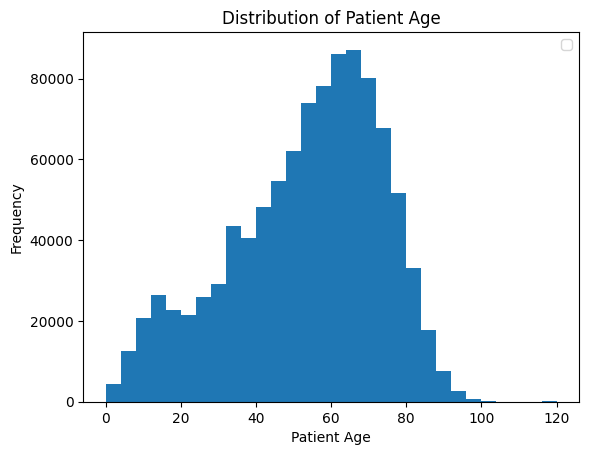

In [23]:
age = (
    age_limited
    .select("patient_0_patient_age")
    .filter(pl.col("patient_0_patient_age").is_not_null())
    .collect()
    .sample(1000000)
    .to_pandas()["patient_0_patient_age"]
)

plt.hist(age, bins=30)
plt.xlabel("Patient Age")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Patient Age")
plt.show()

# 2. sequence_number_outcome one-hot encoding

In [24]:
def sequence_number_outcome_clean(lf, col_name):
    """
    patient_0_sequence_number_outcome 컬럼을 one hot encoding (LazyFrame 유지)
    """
    
    outcome_mapping = {
        'Life Threatening': 'L',
        'Hospitalization': 'H',
        'Disability': 'S',
        'Congenital Anomaly': 'C',
        'Required Intervention': 'R',
        'Death': 'D',
        'Other': 'O',
        'Invalid Data': 'O',
        'Unknown': 'O',
        'No Information': 'O',
        'Not Applicable': 'O',
    }
    
    # 모든 가능한 outcome 코드
    all_outcomes = ['L', 'H', 'S', 'C', 'R', 'D', 'O']
    
    result = lf.with_columns(
        pl.col(col_name)
        .str.replace_all(r'^\[|\]$', "")
        .str.replace_all(r"'", "")
        .str.split(",")
        .list.eval(pl.element().str.strip_chars())
        .alias("_outcome_list")
    )
    
    # 매핑 적용
    for key, value in outcome_mapping.items():
        result = result.with_columns(
            pl.col("_outcome_list")
            .list.eval(pl.element().str.replace(key, value))
            .alias("_outcome_list")
        )
    
    # 각 outcome에 대해 one-hot 컬럼 생성
    for outcome in all_outcomes:
        result = result.with_columns(
            pl.col("_outcome_list")
            .list.contains(outcome)
            .cast(pl.Int32)
            .alias(f"outcome_{outcome}")
        )
    
    result = result.drop("_outcome_list", col_name)
    
    return result

In [25]:
# 상위 10개 행만 처리해서 확인
test_result = (
    sequence_number_outcome_clean(lf.head(100), "patient_0_sequence_number_outcome")
    .collect()
)

test_result.select(['outcome_L', 'outcome_H', 'outcome_S', 'outcome_C', 'outcome_R', 'outcome_D', 'outcome_O'])

outcome_L,outcome_H,outcome_S,outcome_C,outcome_R,outcome_D,outcome_O
i32,i32,i32,i32,i32,i32,i32
null,null,null,null,null,null,null
null,null,null,null,null,null,null
null,null,null,null,null,null,null
null,null,null,null,null,null,null
null,null,null,null,null,null,null
…,…,…,…,…,…,…
0,0,0,0,0,0,1
null,null,null,null,null,null,null
0,0,0,0,1,0,0


# 3. manufacturer_g1_name postal code나 zip code 사용해서 매칭

In [26]:
def manufacturer_postal_match(lf, name_col, postal_col):
    """
    manufacturer_g1_name을 manufacturer_g1_postal_code로 매칭시켜서
    이름 없는 것들 채우고 있는 것들 통일하기
    """
    # 우편번호별로 가장 빈도가 높은 이름 선택
    postal_to_name = (
        lf
        .select([name_col, postal_col])
        .filter(pl.col(name_col).is_not_null() & pl.col(postal_col).is_not_null())
        .unique()
        .group_by(postal_col)
        .agg(
            pl.col(name_col).mode().first().alias("canonical_name")
        )
    )
    
    # 원본 데이터에 매핑 테이블 조인
    result = (
        lf
        .join(
            postal_to_name,
            on=postal_col,
            how="left"
        )
        .with_columns(
            # canonical_name이 있으면 사용, 없으면 원래 이름 유지
            pl.coalesce(pl.col("canonical_name"), pl.col(name_col)).alias(name_col)
        )
        .drop("canonical_name")
    )
    
    return result

In [27]:
match_test_result = manufacturer_postal_match(lf.head(100000), 'device_0_manufacturer_d_name', 'device_0_manufacturer_d_postal_code').collect()

match_test_result.select(['device_0_manufacturer_d_name', 'device_0_manufacturer_d_postal_code'])

device_0_manufacturer_d_name,device_0_manufacturer_d_postal_code
str,str
null,null
"""LIFE2O""","""76051"""
"""FISHER & PAYKEL HEALTHCARE LTD""","""2013"""
"""DT MEDTECH LLC, A VILEX COMPAN…","""37110"""
"""LIFE2O""","""76051"""
…,…
"""ALCON RESEARCH, LLC - ALCON PR…","""19608"""
"""RESPIRONICS, INC.""","""15668"""
"""RESMED PTY LTD""","""2153"""


# 4. device_operator other 결측치 처리, 타입 bool 변환

In [ ]:
def device_operator_clean(lf, col_name):
    """
    device_0_device_operator 컬럼 클린징 함수
    "HEALTH PROFESSIONAL"을 1, "LAY USER/PATIENT"을 0, 그 외는 null로 변환
    """
    return lf.with_columns(
        pl.when(pl.col(col_name) == "HEALTH PROFESSIONAL")
        .then(True)
        .when(pl.col(col_name) == "LAY USER/PATIENT")
        .then(False)
        .otherwise(None)
        .cast(pl.Boolean)
        .alias(col_name)
    )

# 5. device_report_product_code 특문 시작 코드 2개 삭제(-, ---)

In [28]:
def product_code_clean(lf, col_name):
    """
    device_0_device_product_code 컬럼의 영어 대문자 이외 문자 제거
    """
    return lf.with_columns(
        pl.col(col_name)
        .str.replace_all(r'[^A-Z]', '')  # 영어 대문자 이외 문자 제거
        .alias(col_name)
    )

# 6. openfda_device_name 
* 기본적인 전처리만 하고 제품 코드랑 비교해서 통일시키기 -> device_name이 product_code와 1대1이 될 수 있게 만들기

In [29]:
def device_name_clean(lf, col_name):
    """
    device_0_device_name 컬럼의 특수문자 제거 및 소문자 변환
    """
    return lf.with_columns(
        pl.col(col_name)
        .str.replace_all(r'[^a-zA-Z0-9\s]', '')  # 특수문자 제거
        .str.to_lowercase()  # 소문자 변환
        .str.strip_chars()  # 앞뒤 공백 제거
        .str.replace_all(r'\s+', ' ')  # 연속된 공백을 하나로
        .alias(col_name)
    )
    
def device_name_product_code_match(lf, name_col, code_col):
    """
    device_0_device_name과 device_0_device_product_code를 매칭시켜서
    한 product_code에 여러 device_name이 있는 경우 가장 빈도가 높은 이름으로 통일
    """
    # product_code별로 가장 빈도가 높은 device_name 선택
    code_to_name = (
        lf
        .select([name_col, code_col])
        .filter(pl.col(name_col).is_not_null() & pl.col(code_col).is_not_null())
        .group_by([code_col, name_col])  # 먼저 그룹화해서 빈도 계산
        .count()
        .sort("count", descending=True)
        .group_by(code_col)
        .first()  # 각 code별 가장 빈도 높은 이름 선택
        .select([code_col, pl.col(name_col).alias("canonical_name")])
    )
    
    # 원본 데이터에 매핑 테이블 조인
    result = (
        lf
        .join(
            code_to_name,
            on=code_col,
            how="left"
        )
        .with_columns(
            pl.coalesce(pl.col("canonical_name"), pl.col(name_col)).alias(name_col)
        )
        .drop("canonical_name")
    )
    
    return result

In [30]:
# 테스트
# 1. device_name 클린징
cleaned = device_name_clean(df.head(10000), "device_0_openfda_device_name")

# 2. product_code와 매칭
result = device_name_product_code_match(cleaned, "device_0_openfda_device_name", "device_0_device_report_product_code")

# 확인
result.select(['device_0_openfda_device_name','device_0_device_report_product_code']).collect()

/var/folders/jz/7b91vg4d00z75sw7vt8q3c3h0000gn/T/ipykernel_13387/1119006600.py:25: DeprecationWarning: `count` was renamed; use `len` instead
  .count()


device_0_openfda_device_name,device_0_device_report_product_code
str,str
null,null
"""glucose oxidase glucose""","""CGA"""
"""humidifier respiratory gas dir…","""BTT"""
"""prosthesis ankle uncemented no…","""NTG"""
"""reagent occult blood""","""KHE"""
…,…
"""implant endosseous rootform""","""DZE"""
"""sensor glucose invasive nonadj…","""PZE"""
"""implant endosseous rootform""","""DZE"""
